In [3]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd,gluon,nd
from mxnet.gluon import data as gdata,loss as gloss,nn

In [4]:
'''生成数据集'''
#y = 1.2x − 3.4x2+ 5.6x + 5 + ϵ,
#其中噪声ϵ服从均值为0，标准查为0.1的正态分布，训练数据集和测试数据集的样本数都设为100
n_train,n_test,true_w,true_b = 100,100,[1.2,-3.4,5.6],5
#单列数据
features = nd.random.normal(shape=(n_train + n_test,1))
#三列数据
poly_features = nd.concat(features,nd.power(features,2),nd.power(features,3))
#得到标签
#这是NDArray的取某列，和python的区间选择区分开
#这里的某列最终表现为横排数组，最终得到一个横排的结果，并不是矩阵乘法
labels = ( true_w[0] * poly_features[:,0] + true_w[1] * poly_features[:,1] + true_w[2] * poly_features[:,2] + true_b)
#加上噪音,噪音值服从均值为0、标准差为0.1的正态分布
labels += nd.random.normal(scale=0.1,shape=labels.shape)

#查看数据集合的前两个样本
#python的取前几个值
features[:2],poly_features[:2],labels[:2]
'''
取第一列的三个值横着排，乘以第一个权重，
取第二列的三个值横着排，乘以第二个权重
取第三列的三个值横着排，乘以第三个权重
最后三个数组相加，得到一个横排的三个结果

'''

'\n取第一列的三个值横着排，乘以第一个权重，\n取第二列的三个值横着排，乘以第二个权重\n取第三列的三个值横着排，乘以第三个权重\n最后三个数组相加，得到一个横排的三个结果\n\n'

In [5]:
'''作图函数'''
#我们先定义作图函数semilogy，其中y轴使用了对称角度
#本函数已保存在d2lzh包中方便以后使用
def semilogy(x_vals,y_vals,x_label,y_label,x2_vals=None,y2_vals=None,legend=None,figsize=(3.5,2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals,y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals,y2_vals,linestyle=':')
        d2l.plt.legend(legend)

'''定义、训练、和测试模型'''
num_epochs,loss = 100,gloss.L2Loss()
def fit_and_plot(train_features,test_features,train_labels,test_labels):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    #初始化一下
    net.initialize()
    #小批次
    batch_size = min(10,train_labels.shape[0])
    #读取数据集合
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features,train_labels),batch_size,shuffle=True)
    #优化算法
    trainer = gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':0.01})
    
    #预置显示的内容
    train_ls,test_ls = [],[]
    for _ in range(num_epochs):
        for X,y in train_iter:
            with autograd.record():
                l = loss(net(X),y)
            l.backward()
            trainer.step(batch_size);
        #给训练误差和泛化误差屯值
        train_ls.append(loss(net(train_features),train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features),test_labels).mean().asscalar())
    print('final epoch :train loss',train_ls[-1],'test loss',test_ls[-1])
    #画图
    # 画图参数： x_vals,y_vals,x_label,y_label,x2_vals=None,y2_vals=None,legend=None,figsize=(3.5,2.5)
    #这里的range应该是返回一个可迭代对象，1到101
    semilogy(range(1,num_epochs+1),train_ls,'epochs','loss',range(1,num_epochs+1),test_ls, ['train', 'test'])
    #输出一下权重和偏差
    print('weight:',net[0].weight.data().asnumpy(),"\nbias:",net[0].bias.data().asnumpy())
    

final epoch :train loss 0.0068984004 test loss 0.006290898
weight: [[ 1.1771314 -3.3925374  5.603248 ]] 
bias: [4.9868364]


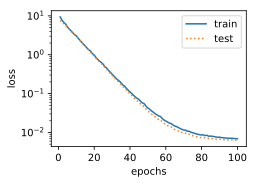

In [6]:
'''三阶多项式函数拟合'''

#train_features,test_features,train_labels,test_labels
#X 前一百后一百，labels也是前一百后一百
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],labels[:n_train], labels[n_train:])




final epoch :train loss 159.3333 test loss 103.10961
weight: [[22.686445]] 
bias: [-0.6586994]


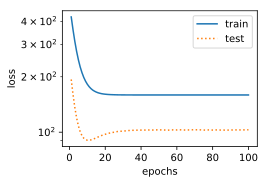

In [9]:
'''线性函数拟合（欠拟合）'''
#我们在试试线性函数拟合，很明显该模型的训练误差在迭代早期下降之后就很难继续降低
#在完成最后一个迭代周期之后，训练误差依然很高
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],labels[n_train:])



final epoch :train loss 0.48075116 test loss 132.96303
weight: [[2.014621  1.9348929 2.0682933]] 
bias: [2.492336]


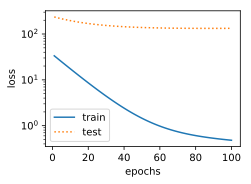

In [10]:
'''样本数量不足（过拟合）'''
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
labels[n_train:])









In [ ]:
'''
总结：
应选用复杂度合适的模型（太简单容易欠拟合），
并尽量避免使用过少的训练样本（太少过拟合）

'''